In [ ]:
# Google Colab does not have with ipympl installed. This doesn't allow for
# interactive figures. Decomment the following code if you wish to run this
# notebook in Google Colab.

'''

!pip install -q ipympl

from google.colab import output
output.enable_custom_widget_manager()

'''

In [ ]:
# If figures aren't showing, try %matplotlib notebook
%matplotlib widget

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import widgets, Layout, Label, HBox, VBox

# Bifurcations with one parameter

## Prologue

This is the first exercise of *Biophysics Assignment 1*. For the second exercise, see the notebook called *Biophysics_Assignment_1_E2*. References to the Notes section are written as [0].

## Problem Statement

The following differential equations describe 4 (separate) dynamical systems with one state variable X and one parameter r.

$X' = rX + X^3 - X^5$

$X' = rX + X^2 - X^3$

$X' = rX - \frac{X}{1 + X^2}$

$X' = X - r + \frac{2 - X}{1 + X^2}$

**Question**: Draw the bifurcation diagrams. Determine the equilibria and the type of bifurcations.

## Solution

OUTLINE

---

In order to make the script as generic as possible, all functions are written inside a class [1].

```
class DynamicalSystem1D:
    ...
```
Specific dynamical systems are implemented by creating a subclass containing a function *get_x_prime*, which returns $X'$ for a given $X$ and $r$.

```
# class DS1(DynamicalSystem1D):
    ...

    @staticmethod
    def get_x_prime(x, r):
        x_prime = r*x + x**3 - x**5
        return x_prime

    ...
```
The script can be easily extended to contain more dynamical systems in this manner.

DYNAMICAL SYSTEM (1D)

---

To understand how equilibria are calculated, we must first dive deeper into the inner workings of the subclasses.

Subclasses contain another function called *get_equilibria_poly*, which turns the expression for $X'$ into a polynomial -- technically, its coefficients -- of which the (complex) roots correspond to the equilibria. This polynomial is calculated in the following manner.

Take $X' = rX - \frac{X}{1 + X^2}$ for example (this is equation 3). If $X = X_0$ is an equilibrium, the following must be true:

$X' = rX_0 - \frac{X_0}{1 + X_0^2} = 0$

Notice however, that $X_0$ is also a root of the polynomial:

$rX_0(1 + X_0^2) - X_0$

This can be easily derived by setting the denominator of each term in the expression for $X'$ the same, and multiplying by this denominator.

Now, back to the main class.

In the *get_equilibria* function, the polynomial gets solved for a given $r$ via the function *np.roots* (the function returns complex equilibria) [2]. The function *plot_equilibria* takes in a minimal and maximal value of $r$ to plot, iterates over a range of $r$ values between these bounds and calculates the equilibria for each $r$.

The *plot_equilibria* function takes in a minimal and maximal value of $r$ of which the (real) equilibria get plotted. The *size* parameter represents the size of the points on the scatter plot [3], but since the interval *rstep* between 2 consecutive values of $r$ is so small, the plot looks like a line.

In [ ]:
class DynamicalSystem1D:
    # color constants
    C_STABLE = 'blue'
    C_UNSTABLE = 'red'

    def get_equilibria(self, r):
        p = self.get_equilibria_poly(r)
        equilibria = np.real_if_close(np.roots(p))
        return equilibria

    # since equilibria are not exact, tol can't be made arbitrarily small
    def is_stable(self, eq, r, tol=0.001):
        return self.get_x_prime(eq + tol, r) < 0

    def plot_x_prime(self, ax, r, xmin, xmax, xstep=0.0005):
        X = np.arange(xmin, xmax, xstep)
        X_prime = self.get_x_prime(X, r)
        lines = ax.plot(X, X_prime, color='black', label=f'r = {r}')

        # plot decoration
        ax.set_xlabel('X')
        ax.set_ylabel('X\'')
        ax.set_title(self.EQUATION)
        ax.legend()

        max_abs = np.max(np.abs(X_prime))
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(-max_abs, max_abs)

        return lines

    # analogous to plot_equilibria (see further)
    def plot_equilibria_fixed_r(self, ax, r):
        X = self.get_equilibria(r)
        X_real = X[np.imag(X) == 0].real

        stable = self.is_stable(X_real, r)
        C = np.full(X_real.size, self.C_UNSTABLE, dtype=str)
        C[stable] = self.C_STABLE
        scatter = ax.scatter(X_real, np.zeros(X_real.size), c=C)
        return scatter

    def plot_equilibria(self, ax, rmin, rmax, rstep, size=0.1):
        R_1D = np.arange(rmin, rmax, rstep)

        # an array of the same size as X is created to call plt.scatter once
        R = np.full((self.MAX_EQUILIBRIA, R_1D.size), R_1D)
        X = np.zeros((self.MAX_EQUILIBRIA, R_1D.size), dtype=complex)

        for i, r in enumerate(R_1D):
            X[:, i] = self.get_equilibria(r)

        # an indexing array, True if the equilbrium is real
        real_idx = (np.imag(X) == 0)
        R_real = R[real_idx].real
        X_real = X[real_idx].real

        # an indexing array, True is the equilibrium is stable
        stable = self.is_stable(X_real, R_real)
        C = np.full(X_real.size, self.C_UNSTABLE, dtype=str)
        C[stable] = self.C_STABLE
        scatter = ax.scatter(R_real, X_real, size, C)

        return scatter

    def plot_stability_arrows(self, ax, R):
        quivers = []
        for r in R:
            X = self.get_equilibria(r)
            X_real = X[np.imag(X) == 0].real

            for x in X_real:
                stable = self.is_stable(x, r)
                pivot = 'tip' if stable else 'tail'
                quivers.append(
                    ax.quiver(
                        r, x, 0, 1, color='black', pivot=pivot,
                        width=0.005, minlength=3
                    )
                )
                quivers.append(
                    ax.quiver(
                        r, x, 0, -1, color='black', pivot=pivot,
                        width=0.005, minlength=3
                    )
                )

        return quivers

    # decorates the bifurcation diagram
    def set_plot_attributes(self, ax, rmin, rmax, xmin, xmax, title=None):
        ax.set_xlabel('r')
        ax.set_ylabel('equilibria X')
        ax.set_title(title)
        ax.set_xlim(rmin, rmax)
        ax.set_ylim(xmin, xmax)

        # set labels (stable and unstable)
        label_lines = [
            mpl.lines.Line2D([0], [0], color=self.C_STABLE),
            mpl.lines.Line2D([0], [0], color=self.C_UNSTABLE)
        ]
        ax.legend(label_lines, ['stable', 'unstable'], loc='upper left')

        return

SUBCLASSES

---

The following block of code contains the subclasses describing the 4 equations. Besides the previously mentioned functions, they contain some constants as well, such as nicely chosen bounds for the plots.

In [ ]:
class DS1(DynamicalSystem1D):
    MAX_EQUILIBRIA = 5
    EQUATION = f'$X\' = rX + X^3 - X^5$'
    R_BOUNDS = -0.75, 1
    X_BOUNDS = -1.8, 1.8

    @staticmethod
    def get_x_prime(x, r):
        x_prime = r*x + x**3 - x**5
        return x_prime

    @staticmethod
    def get_equilibria_poly(r):
        p = np.array([-1, 0, 1, 0, r, 0])
        return p

class DS2(DynamicalSystem1D):
    MAX_EQUILIBRIA = 3
    EQUATION = f'$X\' = rX + X^2 - X^3$'
    R_BOUNDS = -0.5, 1.6
    X_BOUNDS = -1.2, 2.2

    @staticmethod
    def get_x_prime(x, r):
        x_prime = r*x + x**2 - x**3
        return x_prime

    @staticmethod
    def get_equilibria_poly(r):
        p = np.array([-1, 1, r, 0])
        return p

class DS3(DynamicalSystem1D):
    MAX_EQUILIBRIA = 3
    EQUATION = f'$X\'$' + r'$ = rX - \frac{X}{1 + X^2}$'
    R_BOUNDS = -0.4, 1.25
    X_BOUNDS = -4, 4

    @staticmethod
    def get_x_prime(x, r):
        x_prime = r*x - x/(1 + x**2)
        return x_prime

    @staticmethod
    def get_equilibria_poly(r):
        p = np.array([r, 0, r - 1, 0])
        return p

class DS4(DynamicalSystem1D):
    MAX_EQUILIBRIA = 3
    EQUATION = f'$X\'$' + r'$ = X - r + \frac{2 - X}{1 + X^2}$'
    R_BOUNDS = 1.4, 2.2
    X_BOUNDS = -1, 2.8

    @staticmethod
    def get_x_prime(x, r):
        x_prime = x - r + (2 - x)/(1 + x**2)
        return x_prime

    @staticmethod
    def get_equilibria_poly(r):
        p = np.array([1, -r, 0, 2 - r])
        return p

PLOTTING

---

Below are some lists to make the plot interactive via dropdown menus, buttons etc. The dictionary *config* keeps track of what is currently shown on the plot.

In [ ]:
DS = [
    ('Equation 1', DS1),
    ('Equation 2', DS2),
    ('Equation 3', DS3),
    ('Equation 4', DS4)
]

RS = [('Low', 0.001), ('Medium', 0.0005), ('High', 0.0001)] # resolution

n_stability_arrows = 3

In [ ]:
# keep track of what's plotted
config = {
    'lines': [],
    'ds': DS[0][1],
    'resolution': RS[0][1],
    'arrows': True,
    'fixed_r': 0.5
}

def update_config(ds=None, resolution=None, arrows=None, fixed_r=None):
    if ds != config['ds']:
        config['ds'] = ds
    if resolution != config['resolution']:
        config['resolution'] = resolution
    if arrows != config['arrows']:
        config['arrows'] = arrows
    if fixed_r != config['fixed_r']:
        config['fixed_r'] = fixed_r
    return

The following code cell contains the main plot functions.

In [ ]:
def plot_bifurcation(ds, resolution, arrows):
    config['lines'].append(
        ds().plot_equilibria(
            axs[0], ds().R_BOUNDS[0], ds().R_BOUNDS[1], resolution
        )
    )

    if arrows:
        rrange = ds().R_BOUNDS[1] - ds().R_BOUNDS[0]

        # array of r values to plot stability arrows
        R = np.linspace(
            ds().R_BOUNDS[0] + rrange/10,
            ds().R_BOUNDS[1] - rrange/10,
            n_stability_arrows
        )

        config['lines'].append(ds().plot_stability_arrows(axs[0], R))

    ds().set_plot_attributes(
        axs[0],
        rmin=ds().R_BOUNDS[0],
        rmax=ds().R_BOUNDS[1],
        xmin=ds().X_BOUNDS[0],
        xmax=ds().X_BOUNDS[1],
        title=f'Bifurcation diagram'
    )

    return

def plot_x_prime(ds, fixed_r):
    config['lines'].append(
        axs[0].axvline(fixed_r, color='black', linestyle='dashed')
    )
    config['lines'].append(
        axs[1].axhline(color='black', linestyle='dashed')
    )
    config['lines'].append(
        ds().plot_x_prime(axs[1], fixed_r, ds().X_BOUNDS[0], ds().X_BOUNDS[1])
    )
    config['lines'].append(
        ds().plot_equilibria_fixed_r(axs[1], fixed_r)
    )

    return

In [ ]:
def plot_ds(ds, resolution, arrows, fixed_r):
    plot_bifurcation(ds, resolution, arrows)
    plot_x_prime(ds, fixed_r)
    return

In [ ]:
def clear_plot():
    for line in config['lines']:
        try:
            line.remove()
        except:
            [l.remove() for l in line]

    config['lines'] = []
    return

def update_plot(ds, resolution, arrows, fixed_r):
    clear_plot()
    plot_ds(ds, resolution, arrows, fixed_r)
    update_config(ds, resolution, arrows, fixed_r)
    return

Below are handlers for the widgets.

In [ ]:
def on_ds_change(source):
    ds = source['new']
    update_plot(ds, config['resolution'], config['arrows'], config['fixed_r'])
    return

def on_rs_change(source):
    rs = source['new']
    update_plot(config['ds'], rs, config['arrows'], config['fixed_r'])
    return

def on_arrows_change(source):
    arrows = source['new']
    update_plot(config['ds'], config['resolution'], arrows, config['fixed_r'])
    return

def on_fixed_r_change(source):
    r = round(source['new'], 2)
    update_plot(config['ds'], config['resolution'], config['arrows'], r)
    return

In [ ]:
# dropdown menu to choose which equation to plot
ds_dropdown = widgets.Dropdown(
    options=DS,
    value=config['ds'],
    description='',
    button_style='info',
    layout=Layout(width='180px', padding='2px'),
    disabled=False,
    continuous_update=False
)

# buttons to choose the interval between consecutive r values
resolution_btns = widgets.ToggleButtons(
    options=RS,
    value=config['resolution'],
    description='',
    button_style='info',
    layout=Layout(padding='2px'),
    disabled=False,
    continuous_update=False
)

# checkbox to display stability arrows
arrows_checkbox = widgets.Checkbox(
    value=config['arrows'],
    description='Display Stability Arrows',
    layout=Layout(width='180px'),
    indent=False,
    disabled=False
)

# slider for plot of X'
r_slider = widgets.FloatSlider(
    value=config['fixed_r'],
    min=-1,
    max=2.5,
    step=0.05,
    description='r',
    layout=Layout(width='400px'),
    slider_color='blue',
    disabled=False,
    continuous_update=False
)

# add listeners to widgets
ds_dropdown.observe(on_ds_change, names='value')
resolution_btns.observe(on_rs_change, names='value')
arrows_checkbox.observe(on_arrows_change, names='value')
r_slider.observe(on_fixed_r_change, names='value')

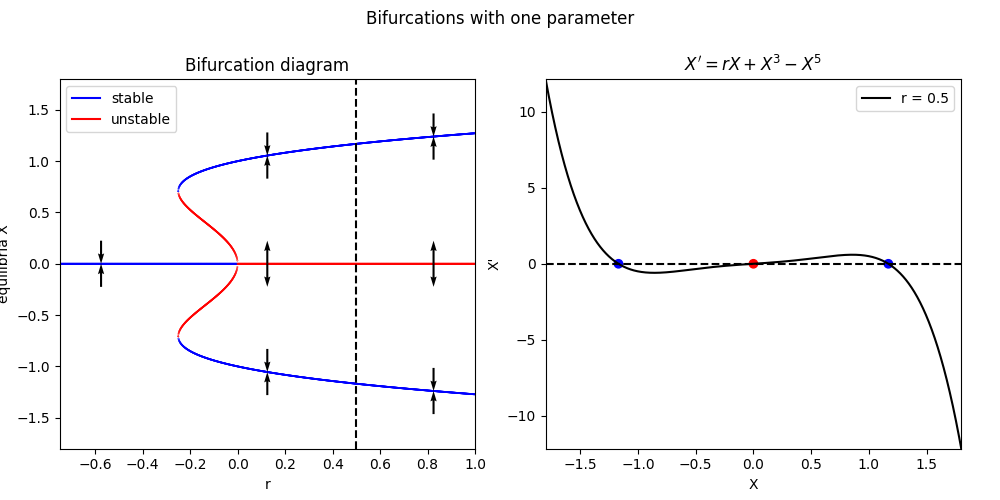

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle('Bifurcations with one parameter')
plt.tight_layout(pad=2)

plot_ds(
    config['ds'],
    config['resolution'],
    config['arrows'],
    config['fixed_r']
)

# widgets
rs_label = Label(
    'Resolution settings (left plot only).\
    \'Low\' is recommended for fast plotting.',
)

VBox([
    HBox([ds_dropdown, resolution_btns]),
    HBox([arrows_checkbox, rs_label, r_slider])
])

The figure above displays the bifurcation diagram (left). Arrows are plotted to indicate the stability of equilibria, but this is also reflected their color. The dashed line depicts the 'slice' of which $X'$ is plotted (right). The equilibria correspond to the zeros of $X'$ and are marked in color, again showing the stability. Equilibria are stable if the slope of $X'$ at that point is negative.

You can choose which equation is displayed via the dropdown menu. Resolution settings can be adjusted for the bifurcation diagram (this changes the interval between consecutive values of $r$). Stability arrows can also be turned off. Finally, the $r$ value for which $X'$ is displayed can be changed via a slider.

EPITOME

---

Equation 1

---

There are 2 saddle nodes at $r = -0.25$: a stable and unstable equilibrium diverge out of nowhere. The unstable equilibria converge to a pitchfork bifurcation at $r = 0$, after which the stable equilibrium $X = 0$ switches to unstable.

Each bifurcation comes with a tipping point. For the saddle nodes, if $r$ is reduced only slightly, the equilibrium jumps to $X = 0$. Also, when $r$ is increased only slightly at $r = 0$, the equilibrium jumps either up or down.

For low values of $r$ ($< -0.25$), there is only the equilibrium $X = 0$. This then increases to no less than 5 equilibria at $r = -0.25$ and finally settles down to 3 equilibria at $r = 0$.

Equation 2

---

Again, there exists a saddle node bifurcation at $r = -0.25$. At $r = 0$, there is a transcritical bifurcation where 2 equilibria collide and exchange stability. $X = 0$ becomes unstable at $r = 0$.

$r = -0.25$ is also a tipping point, in the sense that if $r$ is reduced only slightly, the equilibrium jumps to $X = 0$.

It starts of with 1 equilibrium $X = 0$ and increases to 3 equilibria at $r = -0.25$.

Equation 3

---

There is a pitchfork bifurcation at $r = 1$.

For $r < 0$, $X = 0$ is the only equilibrium (and it's stable). At $r = 0$ however, 2 unstable equilibria arise from $\pm \infty$, to converge again to 1 equilibrium at $r = 1$ (this time unstable).

Equation 4

---

Equation 4 gives rise to 2 saddle nodes at $r = 1.5$ and $r = 2$.

These values of $r$ could also be considered as tipping points, where a slight modification in $r$ results in no stable equilibrium at all.

For low values of $r$ ($< 1.5$), there exists one unstable equilibrium. When $1.5 < r < 2$, three equilibria exist, of which the middle one is stable. Then again at $r > 2$, only one unstable equilibrium exists.

# Notes

[0] This is an example note.

---

[1] This means the code cells can't be split into smaller parts. Therefore, a large portion of the explanation is written at once.

---

[2] The reason we convert $X'$ to a polynomial and use *np.roots* to calculate the equilibria, is the fact that *np.roots* is way faster than using *sp.solve* on the original $X'$ (about 15 times faster).

Note that, we could have also calculated the equilibria $X_0(r)$ as a function of $r$ via *sp.solve* (and turned it into an actual function with *sp.lamdify*). This would be faster than iterating over an array of $r$ and repeatedly calculating the equilibria. Not all equations have analytical solutions $X_0(r)$ however, and so to keep the script as expandable as possible, it was done in the way it is.

For these equations we could have also calculated the inverse $r(X_0)$, but again, this wasn't done to keep everything general.

---

[3] A scatter plot is used instead of a normal plot with lines, because high and low valued equilibria are sometimes switched in *np.roots*' output. This resulted in the occasional horrendous vertical line.